In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from os.path import join, isfile
from os import listdir
import seaborn as sns

In [2]:
def get_json(fname, fpath='../results/arango/'):
    fname = join(fpath, fname)
    with open(fname, 'r') as fp:
        data = json.load(fp)
    return data

In [3]:
sourcepath = '../results/arango/'
only_json = [f for f in listdir(sourcepath) if 
                 isfile(join(sourcepath, f)) 
                 and f[-4:] == 'json']
only_json[:2]

['query5_profile_limit_640.json', 'query4_profile_limit_10.json']

In [4]:
json_items = [(fn.split('_')[0][-1], fn) for fn in only_json]

In [5]:
baselines = [x for x in json_items if len(x[1].split('_')) < 3]
dfb = pd.DataFrame(baselines, columns=['q', 'fname'])
dfb['json'] = dfb.fname.apply(lambda x: get_json(x))
dfb['mean'] = dfb.json.apply(lambda x: 
    np.mean([float(y['executing']) for y in x]))
dfb = dfb.sort_values('q')
bdict = dict(dfb[['q', 'mean']].values)

In [6]:
arrs = [x for x in json_items if len(x[1].split('_')) > 3]
df_main = pd.DataFrame(arrs, columns=['q', 'fname'])
df_main['json'] = df_main.fname.apply(lambda x: get_json(x))
df_main['lim'] = df_main.fname.apply(lambda x: 
            float(x.split('_')[-1].split('.')[0]))
df_main['val'] = df_main.json.apply(lambda x: 
                    [y['executing'] for y in x])
df_main = df_main.explode('val')
df_main.val = df_main.val.astype(np.float)

In [7]:
dfr = df_main.sort_values(['q', 'lim'])[['q', 'lim', 'val']]
dfr.head()

,q,lim,val
12,1,5.0,0.000396
12,1,5.0,0.000280
12,1,5.0,0.000226
17,1,10.0,0.000431
17,1,10.0,0.000393


In [8]:
dfb

,q,fname,json,mean
0,1,query1_profile.json,"[{'initializing': 3.337860107421875e-06, 'pars...",101.035518
5,2,query2_profile.json,"[{'initializing': 2.1457672119140625e-06, 'par...",126.004840
2,3,query3_profile.json,"[{'initializing': 3.337860107421875e-06, 'pars...",21.829566
4,4,query4_profile.json,"[{'initializing': 2.384185791015625e-06, 'pars...",88.581788
1,5,query5_profile.json,"[{'initializing': 3.337860107421875e-06, 'pars...",245.488133
3,6,query6_profile.json,"[{'initializing': 2.86102294921875e-06, 'parsi...",296.067761


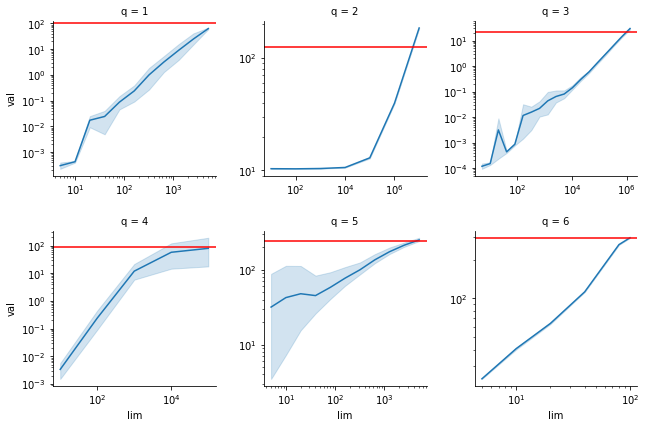

In [9]:
g = sns.FacetGrid(dfr, col='q', sharex=False, sharey=False, 
                  col_wrap=3, margin_titles=True)
g.map(sns.lineplot, 'lim', 'val').set(yscale='log').set(xscale='log')
for j, ax in enumerate(g.axes):
    ax.axhline(bdict[str(j+1)], c='r')